<a href="https://colab.research.google.com/github/scardenol/ai_2023/blob/main/3.%20Unsupervised/avances_Salo/density_and_distance_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Load required libraries

In [1]:
# Install UMAP library
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=55dd429135e2524a5221c2550f806fbb1bd60562c6f1655943961bfadf4fd0b2
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=3263f666a5b04900947d83ebae0e03906c4931baaa70db04d0a4e01dd902479a
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [2]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors
import umap
import pandas as pd
import seaborn as sns

# UMAP for non-linear dimensionality reduction

The Uniform Manifold Approximation and Projection (UMAP) is a non-linear dimensionality reduction algorithm used for visualizing and clustering high-dimensional data. It works by preserving the local structure of the data while optimizing a low-dimensional representation that is easier to visualize and analyze.

## Example on iris data set

In [3]:
# Load the data
iris = sns.load_dataset('iris')
X = iris.drop('species', axis=1)

In [4]:
def normalize_data(X):
    """ Normalize data to be between 0 and 1.
    Args:
        X (_np.array_): the data to be normalized.
    Returns:
        _np.array_: the normalized data.
    """
    X = X - np.min(X, axis=0)
    X = X / np.max(X, axis=0)
    return X

In [5]:
# Normalize data to the hypercube [0,1]
X = normalize_data(X)
iris.iloc[:,:-1] = X

In [6]:
# Fit the UMAP model and transform the data. Embed the data to a 2D space (n_components)
reducer = umap.UMAP(n_components=2, metric="euclidean", min_dist=0.3, n_neighbors=5)
embedding = reducer.fit_transform(X)

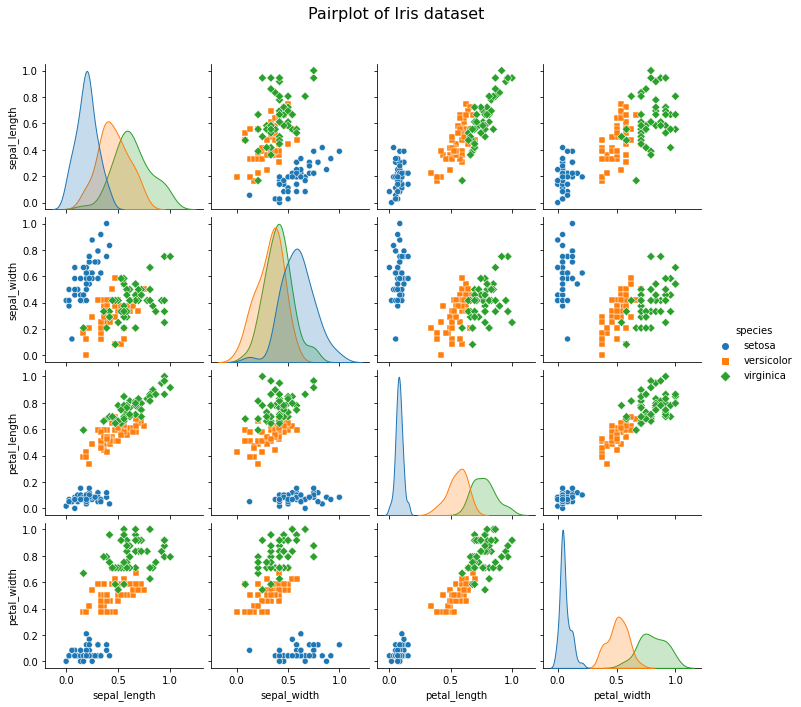

In [7]:
# Plot the original data set
g = sns.pairplot(data=iris, hue='species', markers=["o", "s", "D"]);
g.fig.suptitle("Pairplot of Iris dataset", size=16)
g.figure.subplots_adjust(top=.9)

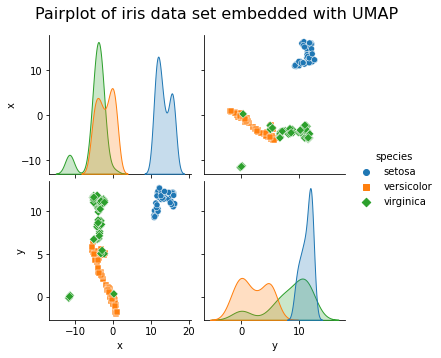

In [8]:
# Plot the reduced data in 2D
embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
embedding_df['species'] = iris['species']
g = sns.pairplot(data=embedding_df, hue='species', markers=["o", "s", "D"])
g.fig.suptitle("Pairplot of iris data set embedded with UMAP", size=16)
g.figure.subplots_adjust(top=.9)

# Clustering algorithms




In this section we focus on the implementation of density-based and distance-based clustering algorithms and provide an example with the iris data set ("toy data") for each algorithm. The algorithms are:


**Density-based**
1. Mountain
2. Substractive
**Distance-based**
3. $k$-means
4. fuzzy $c$-means

### Auxiliary functions



In [9]:
# Plot data in 2D and 3D

def plot_data(X, Y, labels, colors=None, hold_on=False):
    """ Plot the data with colored labels and legend.
    Args:
        X (_np.array_): the data to be plotted.
        Y (_np.array_): the labels of the data.
        labels (_list_): the labels of the data.
        colors (_list_): the colors to be used for the data.
        hold_on (_bool_): whether to hold on to the current plot or not.
    """
    if not hold_on:
        plt.figure(figsize=(8, 6))
    if colors is not None:
        color = itertools.cycle(colors)
    for i in range(len(labels)):
        x, y = X[Y==i, 0], X[Y==i, 1]
        if colors is None:
            plt.scatter(x, y, label=labels[i])
        else:
            plt.scatter(x, y, label=labels[i], color=next(color))
    plt.legend()
    if not hold_on:
        plt.show()

# Plot the data in 3D
def plot_data_3d(X, Y, labels, colors=None, hold_on=False, ax=None):
    """ Plot the data in 3D.
    Args:
        X (_np.array_): the data to be plotted.
        Y (_np.array_): the labels of the data.
        labels (_list_): the labels of the data.
        colors (_list_): the colors to be used for the data.
        hold_on (_bool_): whether to hold on to the current plot or not.
        ax (_matplotlib.axes.Axes_): the axes to plot on.
    Raises:
        ValueError: if hold_on is True and ax is None.
    """
    if not hold_on:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    elif ax is None:
        raise ValueError('If hold_on is True, then ax must be provided')
    else:
        ax = ax
    if colors is not None:
        color = itertools.cycle(colors)
    for i in range(len(labels)):
        x, y, z = X[Y==i, 0], X[Y==i, 1], X[Y==i, 2]
        if colors is None:
            ax.scatter(x, y, z, label=labels[i])
        else:
            ax.scatter(x, y, z, label=labels[i], color=next(color))
    if not hold_on:
        plt.show()

In [10]:
# Create and plot grid space

def create_grid_space(granularity=100, dimensions=2):
    """Create a grid space of points that can be used to color the points in the data set.
    Args:
        granularity (_int_): the number of points in each dimension of the grid space.
        dimensions (_int_): the number of dimensions of the grid space.
    Returns:
        _np.array_: a numpy array containing the grid space points or coordinates.
    """
    grid_space = np.meshgrid(*[np.linspace(0, 1, granularity) for _ in range(dimensions)])
    grid_space = np.array([x.flatten() for x in grid_space]).T
    return grid_space

def plot_grid_space(grid_space, hold_on=False, ax=None):
    """Plot the grid space. If the number of dimensions is 2, then plot the grid space as a scatter plot.
    If the  number of dimensions is 3, then plot the grid space as a 3D scatter plot. If the number of
    dimensions is greater than 3, then plot the grid space as a 2D scatter plot with the first two dimensions.
    If the number of dimensions is 1, then plot the grid space as points.
    Args:
        grid_space (_np.array_): the grid space to be plotted.
        hold_on (_bool_): whether to hold on to the current plot or not.
        ax (_matplotlib.axes.Axes_): the axes to plot on.
    """
    if not hold_on:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    elif grid_space.shape[1] >= 3 and ax is None:
        raise ValueError('If hold_on is True for spaces >= 3D, then ax must be provided')
    else:    
        ax = ax
    if (
        grid_space.shape[1] == 2
    ):
        plt.scatter(grid_space[:, 0], grid_space[:, 1], label='grid space')
    elif grid_space.shape[1] >= 3:
        ax.scatter(grid_space[:, 0], grid_space[:, 1], grid_space[:, 2], label='grid space')
    elif grid_space.shape[1] == 1:
        plt.scatter(grid_space[:, 0], np.zeros(grid_space.shape[0]), label='grid space')
    if not hold_on:
        plt.legend()
        plt.show()

def plot_gridAndData(grid_space, with_data=False, X=None, Y=None, labels=None):
    """ Plot the grid space and the data.
    Args:
        grid_space (_np.array_): the grid space to be plotted.
        with_data (_bool_): whether to plot the data or not.
        X (_np.array_): the data to be plotted.
        Y (_np.array_): the labels of the data.
        labels (_list_): the labels of the data.
    """
    fig = plt.figure(figsize=(8, 6))
    if with_data:
        X, Y, labels = X, Y, labels
    if grid_space.shape[1] >= 3 and X.shape[1] >= 3:
        ax = fig.add_subplot(111, projection='3d')
        plot_grid_space(grid_space, hold_on=True, ax=ax)
        if with_data:
            plot_data_3d(X, Y, labels, hold_on=True, ax=ax)
    else:
        ax = fig.add_subplot(111, projection=None)
        plot_grid_space(grid_space, hold_on=True)
        if with_data:
            plot_data(X, Y, labels, hold_on=True)
    plt.legend()
    plt.show()
    

In [11]:
# Functions to visualize results
def unique_list(l):
    """ Take a list and return a list of the unique values in the order of appearance of the original list.
    
    Args:
        l (list): the list to be processed.

    Returns:
        list: the list of unique values in the order of appearance of the original list.
    """
    seen = set()
    return [x for x in l if x not in seen and not seen.add(x)]

def plot_2Dclusters(X, Y, labels, C, Y_hat):
    """ Plot data, centers and center membership in 2D.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the labels of the data.
        labels (list): the labels of the clusters.
        C (np.array): the cluster centers.
        Y_hat (np.array): the resulting cluster labels.
    """
    plt.figure(figsize=(8, 6))
    # Red, green, blue
    colors = ['#DF2020', '#81DF20', '#2095DF']
    
    # Reorder labels
    order = unique_list(Y_hat)
    labels = labels[order]
    # Plot data
    plot_data(X, Y, labels, colors=colors, hold_on=True)
    # Convert colors to numpy array and reorder to match the order of the estimated clusters
    colors = np.array(colors)
    colors = colors[order]
    # Plot centers
    plt.scatter(C[:, 0], C[:, 1], c='black', label='center')
    # iterate over each data point and each cluster center, and plot lines only if the data point is in the cluster
    for i in range(X.shape[0]):
        for j in range(C.shape[0]):
            if Y_hat[i] == j:
                plt.plot([X[i, 0], C[j, 0]], [X[i, 1], C[j, 1]], color=colors[j], alpha=0.2)
    plt.legend()
    plt.show()

def plot_3Dclusters(X, Y, labels, C, Y_hat):
    """Plot data, centers and center membership in 3D.
    
    Args:
        X (numpy array): data points
        Y (numpy array): data labels
        labels (list): list of labels
        C (numpy array): cluster centers
        Y_hat (numpy array): estimated cluster membership
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    # Red, green, blue
    colors = ['#DF2020', '#81DF20', '#2095DF']
    colors_map = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    
    # Reorder labels
    order = unique_list(Y_hat)
    labels = labels[order]
    # Plot data
    plot_data_3d(X, Y, labels, colors=colors, hold_on=True, ax=ax)
    # Convert colors to numpy array and reorder to match the order of the estimated clusters
    colors = np.array(colors)
    colors = colors[order]
    # Plot centers
    ax.scatter(C[:, 0], C[:, 1], C[:, 2], c='black', label='center')
    # iterate over each data point and each cluster center, and plot lines only if the data point is in the cluster
    for i in range(X.shape[0]):
        for j in range(C.shape[0]):
            if Y_hat[i] == j:
                ax.plot([X[i, 0], C[j, 0]], [X[i, 1], C[j, 1]], [X[i, 2], C[j, 2]], color=colors[j], alpha=0.2)
    plt.legend()
    plt.show()

In [43]:
# Transform membership matrix into cluster labels.
def membership_to_labels(membership):
    """ Transform membership matrix into cluster labels.
    
    Args:
        membership (np.array): the membership matrix.
        
    Returns:
        np.array: the resulting cluster labels.
    """
    return np.argmax(membership, axis=1)

def relabel_clusters(Y, Y_hat):
    """ Relabel the clusters so that the clusters are labeled in the same order as the original data. Make sure
    that the unique values are the same.
    
    Args:
        Y (np.array): the labels of the data.
        Y_hat (np.array): the labels of the clusters.

    Returns:
        np.array: the relabeled clusters.
    """
    Y_unique = unique_list(Y)
    Y_hat_unique = unique_list(Y_hat)
    Y_hat_relabel = np.zeros_like(Y_hat)
    for i, y in enumerate(Y_unique):
        Y_hat_relabel[Y_hat == Y_hat_unique[i]] = y
    return Y_hat_relabel

## Distance function
We consider 4 distance norms: Manhattan, Euclidean, Mahalanobis and Cosine.

In [12]:
def distance(x, y, dist_type):
    """Distance function.
    
    Args:
        x (np.array): the first point.
        y (np.array): the second point.
        dist_type (str or float or int): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine.
    
    Returns:
        float: the distance between the two n-dimensional points or vectors.
    """
    if dist_type == 1:
        return np.sum(np.abs(x - y))
    elif dist_type == 2:
        return np.sqrt(np.sum((x - y) ** 2))
    elif dist_type == "mahal":
        return np.sqrt((x-y).T @ np.linalg.inv(np.cov(x)) @ (x-y))
    elif dist_type == "cos":
        return 1 - np.dot(x, y) / (np.sqrt(np.sum(x ** 2)) * np.sqrt(np.sum(y ** 2)))
    else:
        raise ValueError("Invalid distance type.")

## Mountain

In [13]:
def mountain_clustering(X, granularity, sigma, beta=None, dist_type=2):
    """A clustering algorithm that uses a mountain matrix to cluster data.

    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        granularity (_int_): the granularity of the grid space, i.e., the number of points in each dimension.
        K (_int_): the number of clusters.
        sigma (_float_): the height and the smoothing of the mountain function. Is an application specific parameter, that
        acts as the kernel influence or bandwidth for the mountain function construction and update.
        beta (_float_, optional): the height and the smoothing of the updated mountain function. Defaults to None, as it
        is internally defined as 2*sigma.
        dist_type (_int_, optional): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine. Defaults to 2.

    Returns:
        _tuple_: a tuple containing the cluster centers, the resulting cluster labels and the mountain matrix.
    """
    if beta is None:
        beta = 2*sigma

    num_obs, num_features = X.shape
    num_grid_points = granularity**num_features
    
    # Assume a big fixed number of clusters
    K = 100

    # Create grid space (array where each row is a point in the grid space or a tuple of coordinates)
    grid_space = create_grid_space(granularity=granularity, dimensions=num_features)
    # Initialize mountain matrix and mountain centers
    M = np.zeros(num_grid_points)
    M_centers = np.zeros(K)
    # Initialize cluster centers
    C = np.zeros(shape=(K, num_features))
    C_idx = np.zeros(K).astype(int)

    # Calculate the mountain matrix for the remaining cluster centers (except the first one)
    cluster = 0
    while True:
        print(f'Calculating cluster center {cluster}...')
        for i, point in enumerate(grid_space):
            for j in range(num_obs):
                if cluster == 0:
                    M[i] += np.exp(-distance(point, X[j,:], dist_type)**2 / (2*sigma**2))
                else:
                    M[i] = M[i] - M[C_idx[cluster-1]]*np.exp(-distance(point, C[cluster-1], dist_type)**2 / (2*beta**2))
        
        # Get index of maximum value in mountain matrix
        C_idx[cluster] = int(np.argmax(M))
        # Set current cluster as the maximum value in mountain matrix
        new_center = grid_space[C_idx[cluster], :]
        
        # Stop criteria Check if the new center is already in the list of centers or if the mountain value is too small.
        if ( np.any(np.equal(C, new_center).all(axis=1)) ) or (
            M[C_idx[cluster]] < min(1e-3, 0.5/(granularity-1))
        ):
            C = C[:cluster, :]
            C_idx = C_idx[:cluster]
            M_centers = M_centers[:cluster]
            print(f'Number of clusters found: {cluster} \n with points {C}')
            break
        
        # Update the cluster centers and mountain centers
        C[cluster, :] = new_center
        M_centers[cluster] = M[C_idx[cluster]]
        
        # Print the current cluster center and mountain center value
        print(f'Cluster center {cluster} : {C[cluster]}')
        print(f'Mountain center value {M_centers[cluster]}')
        
        # Advance to the next cluster
        cluster += 1

    # Calculate which points are within each cluster
    Y_hat = np.zeros(num_obs)
    Y_hat = np.argmin(np.linalg.norm(X[:, np.newaxis, :] - C[np.newaxis, :, :], axis=2), axis=1)
    return C, Y_hat, M

### Example on iris data set

In [14]:
# Reload the data
iris = load_iris()
X, Y, labels = iris.data, iris.target, iris.target_names

# Normalize data to the hypercube [0,1]
X = normalize_data(X)

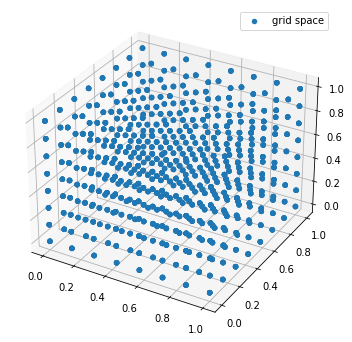

In [15]:
# Visualize an example grid space
grid_space = create_grid_space(granularity=8, dimensions=X.shape[1])
plot_grid_space(grid_space)


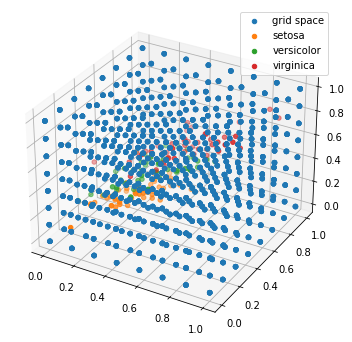

In [16]:
# Visualize grid space and data
plot_gridAndData(grid_space, with_data=True, X=X, Y=Y, labels=labels)

In [17]:
# Run mountain clustering
C, Y_hat, M = mountain_clustering(X, granularity=2, sigma=0.2, dist_type=2)

Calculating cluster center 0...
Cluster center 0 : [0. 1. 0. 0.]
Mountain center value 3.8438099103680727
Calculating cluster center 1...
Cluster center 1 : [1. 0. 1. 1.]
Mountain center value 1.034676050394805
Calculating cluster center 2...
Cluster center 2 : [1. 1. 1. 1.]
Mountain center value 0.8288423341872719
Calculating cluster center 3...
Number of clusters found: 3 
 with points [[0. 1. 0. 0.]
 [1. 0. 1. 1.]
 [1. 1. 1. 1.]]


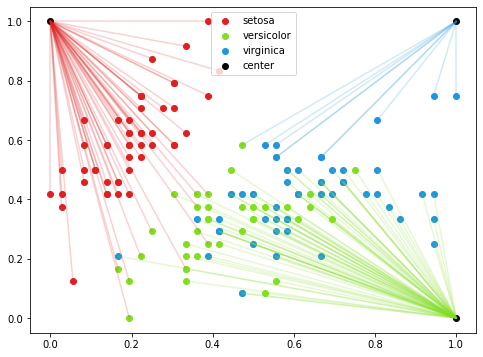

In [18]:
# Visualize results in 2D
plot_2Dclusters(X, Y, labels, C, Y_hat)

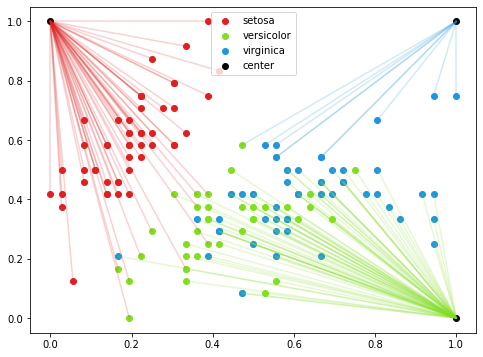

In [19]:
# Visualize results in 3D
plot_2Dclusters(X, Y, labels, C, Y_hat)

## Substractive

In [20]:
def substractive_clustering(X, sigma, beta=None, dist_type=2, tol = 1e-3):
    """A clustering algorithm that uses a mountain matrix to cluster data.

    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        K (_int_): the number of clusters.
        sigma (_float_): the height and the smoothing of the mountain function. Is an application specific parameter, that
        acts as the kernel influence or bandwidth for the mountain function construction and update.
        beta (_float_, optional): the height and the smoothing of the updated mountain function. Defaults to None, as it
        is internally defined as 2*sigma.
        dist_type (_int_, optional): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine. Defaults to 2.
        tol (_float_, optional): the tolerance for the stopping criterion. Defaults to 1e-3.

    Returns:
        _tuple_: a tuple containing the cluster centers, the resulting cluster labels and the mountain matrix.
    """
    if beta is None:
        beta = 2*sigma

    num_obs, num_features = X.shape
    
    # Assume a big fixed number of clusters
    K = 100

    # Initialize mountain matrix and mountain centers
    density= np.zeros(num_obs)
    density_centers = np.zeros(K)
    # Initialize cluster centers
    C = np.zeros(shape=(K, num_features))
    C_idx = np.zeros(K).astype(int)

    # Calculate the mountain matrix for the remaining cluster centers (except the first one)
    cluster = 0
    while True:
        print(f'Calculating cluster center {cluster}...')
        for i in range(num_obs):
            for j in range(num_obs):
                if cluster == 0:
                    density[i] += np.exp(-distance(X[i,:], X[j,:], dist_type) / (sigma/2)**2)
                else:
                    density[i] -= density_centers[cluster-1]*np.exp(-distance(X[i,:], C[cluster-1], dist_type) / (beta/2)**2)
        
        # Get index of maximum value in mountain matrix
        C_idx[cluster] = int(np.argmax(density))
        # Set current cluster as the maximum value in mountain matrix
        new_center = X[C_idx[cluster], :]
        new_density = density[C_idx[cluster]]
        # Stop criteria Check if the new center is already in the list of centers or if the mountain value is too small.
        if ( np.any(np.equal(C, new_center).all(axis=1)) ) or (
            abs(new_density) < tol) or (abs(new_density / density_centers[cluster-1]) < 1e-1
        ):
            C = C[:cluster, :]
            C_idx = C_idx[:cluster]
            density_centers = density_centers[:cluster]
            print(f'Number of clusters found: {cluster} \n with points {C}')
            break
        
        # Update the cluster centers and mountain centers
        C[cluster, :] = new_center
        density_centers[cluster] = density[C_idx[cluster]]
        
        # Print the current cluster center and mountain center value
        print(f'Cluster center {cluster} : {C[cluster]}')
        print(f'Mountain center value {density_centers[cluster]}')
        
        # Advance to the next cluster
        cluster += 1

    # Calculate which points are within each cluster
    Y_hat = np.zeros(num_obs)
    Y_hat = np.argmin(np.linalg.norm(X[:, np.newaxis, :] - C[np.newaxis, :, :], axis=2), axis=1)
    return C, Y_hat, density

### Example on iris data set

In [22]:
# Run substractive clustering
C, Y_hat, density = substractive_clustering(X, sigma=0.4, dist_type = 2, tol = 1e-3)

Calculating cluster center 0...


<ipython-input-20-5abf19c96e00>:51: RuntimeWarning: divide by zero encountered in double_scalars
  abs(new_density) < tol) or (abs(new_density / density_centers[cluster-1]) < 1e-1


Cluster center 0 : [0.22222222 0.58333333 0.08474576 0.04166667]
Mountain center value 4.368703878901702
Calculating cluster center 1...
Cluster center 1 : [0.72222222 0.5        0.79661017 0.91666667]
Mountain center value 1.6621981911324384
Calculating cluster center 2...
Cluster center 2 : [0.16666667 0.20833333 0.59322034 0.66666667]
Mountain center value -4.520939495376534
Calculating cluster center 3...
Number of clusters found: 3 
 with points [[0.22222222 0.58333333 0.08474576 0.04166667]
 [0.72222222 0.5        0.79661017 0.91666667]
 [0.16666667 0.20833333 0.59322034 0.66666667]]


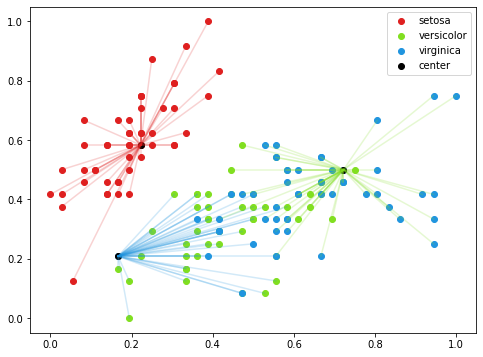

In [23]:
# Visualize results in 2D
plot_2Dclusters(X, Y, labels, C, Y_hat)

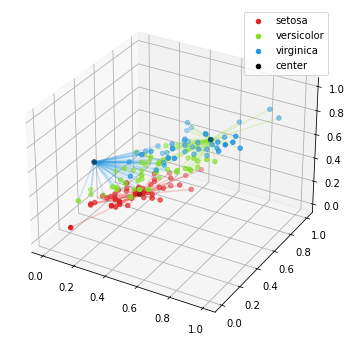

In [25]:
# Visualize results in 3D
plot_3Dclusters(X, Y, labels, C, Y_hat)

## $k$-means

In [26]:
def kmeans(x, k, max_iter=100, tol=1e-3, dist_type=2, verbose=False, init=None):
    """ K-means algorithm.
    
    Args:
        x (np.array): the features of data to be clustered, usually structured as tidy data.
        k (int): the number of clusters.
        max_iter (int): the maximum number of iterations.
        tol (float): the tolerance for the stopping criterion.
        dist_type (str or float or int): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine.
        verbose (bool): whether to print the cost function at each iteration.
        init (list): the initial centers.
        
    Returns:
        np.array: the cluster centers.
        np.array: the resulting cluster labels.
        np.array: the membership matrix.
        np.array: the cost function at each iteration.
    """
    
    if init is None:
        init = []
    n_obs = x.shape[0]
    # Initialization of the centers.
    if init == [] or len(init) != k:
        init = np.random.choice(n_obs, k, replace=False)
    centers = x[init, :]
    costs = np.zeros(max_iter+1)
    iteration = 0
    while True:
        # Determine of membership of each observation to each cluster.
        membership = np.zeros((n_obs, n_obs), dtype=np.int32)
        for j in range(n_obs):
            min_dist = np.inf
            min_idx = 0
            for i, center in enumerate(centers):
                dist = distance(x[j,:], center, dist_type)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = i
            membership[j, min_idx] = 1

        # Compute the cost function.
        cost = 0
        for j in range(n_obs):
            for i in range(k):
                if membership[j, i] == 1:
                    cost = cost + distance(x[j,:], centers[i,:], dist_type)

        costs[iteration-1] = cost
        # Stop criteria Check if the cost function is too small.
        if iteration > 1 and (
            abs(cost - costs[iteration - 2]) < tol or iteration > max_iter
        ):
            break
        # Update the centers.
        for i in range(k):
            centers[i, :] = np.mean(x[membership[:, i] == 1, :], axis=0)

        iteration = iteration + 1

        if verbose:
            print(f'Iteration: {iteration}, Cost: {cost}')

    return centers, membership, costs

### Example on iris data set

In [58]:
# Run k-means
C, membership, costs = kmeans(X, k=3, max_iter=100, tol=1e-3, dist_type=2, verbose=False, init=None)

In [59]:
# Transform membership matrix into cluster labels
Y_hat = membership_to_labels(membership)

In [45]:
# Relabel predicted labels to same order from original labels
#Y_hat = relabel_clusters(Y, Y_hat)

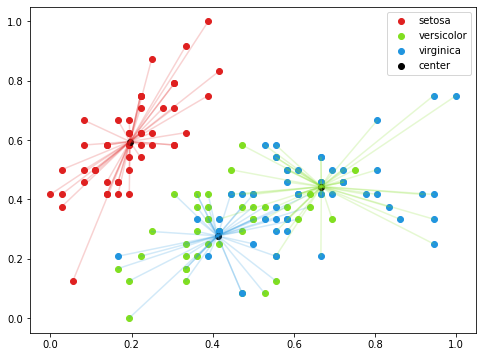

In [60]:
# Visualize results in 2D
plot_2Dclusters(X, Y, labels, C, Y_hat)

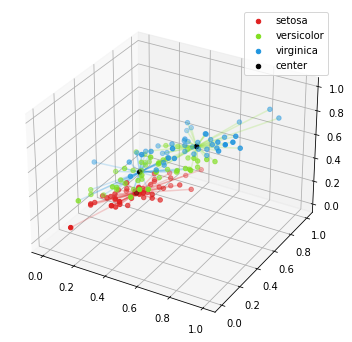

In [61]:
# Visualize results in 3D
plot_3Dclusters(X, Y, labels, C, Y_hat)

## fuzzy $c$-means

In [62]:
def fuzzyCmeans(x, k, m=2, max_iter=100, tol=1e-3, dist_type=2, verbose=False):
    """ Fuzzy C-means algorithm.
    
    Args:
        x (np.array): the features of data to be clustered, usually structured as tidy data.
        k (int): the number of clusters.
        m (float): the fuzziness parameter.
        max_iter (int): the maximum number of iterations.
        tol (float): the tolerance for the stopping criterion.
        dist_type (str or float or int): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine.
        verbose (bool): whether to print the cost function at each iteration.
        
    Returns:
        np.array: the cluster centers.
        np.array: the resulting cluster labels.
        np.array: the membership matrix.
        np.array: the cost function at each iteration.
    """
       
    n_obs, n_features = x.shape
    # Initialization the membership matrix.
    membership = np.random.rand(n_obs, k)
    membership = membership / np.sum(membership, axis=1, keepdims=True)

    iteration = 0
    centers = np.zeros((k, n_features))
    costs = np.zeros(max_iter+1)
    while True:
        # Calculate the centers.
        for i in range(k):
            centers[i, :] = membership[:, i] * m @ x / np.sum(membership[:, i] * m)

        # Compute the cost function.
        cost = 0
        for i in range(k):
            for j in range(n_obs):
                cost = cost + membership[j, i] ** m * distance(centers[i,:], x[j,:], dist_type)
        costs[iteration] = cost
        # Stop criteria Check if the cost function is too small.
        if iteration > 1 and (
            abs(cost - costs[iteration - 2]) < tol or iteration > max_iter
        ):
            break
        # Update the membership matrix.
        for i in range(k):
            for j in range(n_obs):
                den = 0
                for l in range(k):
                    den = den + (distance(x[j,:], centers[i,:], dist_type) / distance(x[j,:], centers[l,:], dist_type)) ** (2/(m-1))
                membership[j, i] = 1 / den

        iteration = iteration + 1

        if verbose:
            print(f'Iteration: {iteration}, Cost: {cost}')

    return centers, membership, costs

### Example on iris data set

In [63]:
# Run fuzzy c-means
C, membership, costs = fuzzyCmeans(X, k=3, m=2, max_iter=100, tol=1e-3, dist_type=2, verbose=False)

In [64]:
# Transform membership matrix into cluster labels
Y_hat = membership_to_labels(membership)

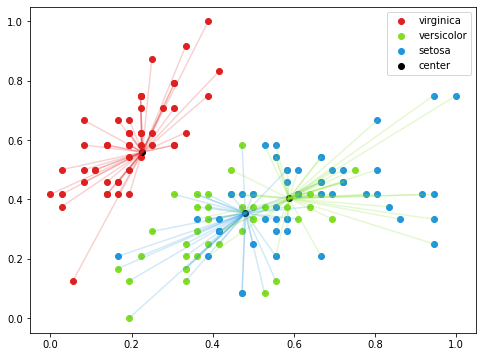

In [65]:
# Visualize results in 2D
plot_2Dclusters(X, Y, labels, C, Y_hat)

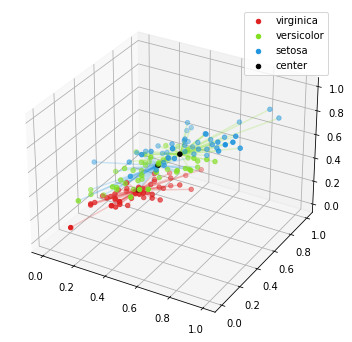

In [66]:
# Visualize results in 3D
plot_3Dclusters(X, Y, labels, C, Y_hat)

# Experiment on real data